## load packages

In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
from google.colab import auth
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
from keras.models import Sequential
from keras.layers import Dense,Flatten,Conv2D,MaxPool2D,Dropout
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import layers, models
import cv2
from PIL import Image



## mount google drive

In [120]:
auth.authenticate_user()
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## load data

In [121]:
X = pd.read_csv('/content/drive/MyDrive/signproject/raw_data/ASL/asl_data_compressed_color.csv')
print(f"data size is {X.shape}")
label = pd.read_csv('/content/drive/MyDrive/signproject/raw_data/ASL/asl_data_label.csv')
print(f"label size is {label.shape}")

data size is (2515, 30000)
label size is (2515, 1)


In [122]:
nx = int((X.shape[1]/3)**0.5)

## Resize the data for training


In [123]:
img_size = 100
resize_image = Sequential([layers.Reshape((nx,nx,3)),layers.Resizing(img_size,img_size)])

In [124]:
if nx != img_size:
  X = np.array(resize_image(np.array(X)))
  nz,nx,ny,nk = X.shape
  X = np.reshape(X,(nz,nx*ny*nk))
  X.shape

## split data into train-test pair and create one hot encoded labels

In [125]:
# split train-test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
# convert label into one hot encoder
lb = LabelBinarizer()
y = lb.fit_transform(label)


In [126]:
# make data adapted to tensorflow tensor format
X_train = X_train.values.reshape(-1,img_size,img_size,3)
X_test = X_test.values.reshape(-1,img_size,img_size,3)/255
X_train.shape

(1685, 100, 100, 3)

In [127]:
print(f"size of one hot encoded labels are {y_train.shape}")


size of one hot encoded labels are (1685, 36)


## plot few samples from the dataset

Text(0.5, 1.0, 'letter: 0    s\nName: 4, dtype: object')

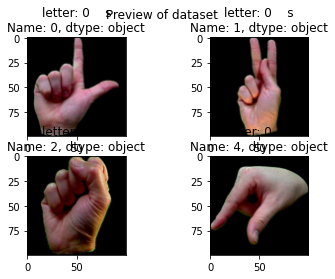

In [130]:
fig, axe = plt.subplots(2,2)
fig.suptitle('Preview of dataset')
axe[0,0].imshow(X_train[0].reshape(100,100,3),cmap='gray')
axe[0,0].set_title(f"letter: {label.loc[0]}")
axe[0,1].imshow(X_train[1].reshape(100,100,3),cmap='gray')
axe[0,1].set_title(f"letter: {label.loc[1]}")
axe[1,0].imshow(X_train[2].reshape(100,100,3),cmap='gray')
axe[1,0].set_title(f"letter: {label.loc[2]}")
axe[1,1].imshow(X_train[4].reshape(100,100,3),cmap='gray')
axe[1,1].set_title(f"letter: {label.loc[4]}")

### Data Augmentation

In [131]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 0.1,
                                  height_shift_range=0.2,
                                  width_shift_range=0.2,
                                  shear_range=0.1,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest',
                                  validation_split=0.3)

In [132]:
def load_model():

    model = VGG16(weights="imagenet", include_top=False, input_shape=X_train[0].shape)
    
    return model

In [133]:
model = load_model()
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

In [134]:
def set_nontrainable_layers(model):
    # Set the first layers to be untrainable
    model.trainable = False
    
    return model

model
model = set_nontrainable_layers(model)

model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

In [135]:
def add_last_layers(model):
    '''Take a pre-trained model, set its parameters as non-trainables, and add additional trainable layers on top'''
    
    base_model = set_nontrainable_layers(model)
    flatten_layer = layers.Flatten()
    dense_layer = layers.Dense(500, activation='relu')
    prediction_layer = layers.Dense(36, activation='softmax')                   
     
    
    model = models.Sequential([
        
        base_model,
        flatten_layer,
        dense_layer,
        prediction_layer
    ])
   
    return model

In [136]:
from tensorflow.keras import optimizers

def build_model():
     
    model = load_model()
    model = add_last_layers(model)
    
    opt = optimizers.Adam(learning_rate=1e-4)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

In [137]:
model = build_model()

In [138]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten_10 (Flatten)        (None, 4608)              0         
                                                                 
 dense_20 (Dense)            (None, 500)               2304500   
                                                                 
 dense_21 (Dense)            (None, 36)                18036     
                                                                 
Total params: 17,037,224
Trainable params: 2,322,536
Non-trainable params: 14,714,688
_________________________________________________________________


In [140]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, verbose=1, restore_best_weights=True)

history = model.fit(train_datagen.flow(X_train,y_train,batch_size=64,subset='training'), 
                    epochs=50,
                    validation_data = train_datagen.flow(X_train,y_train,batch_size=8,subset='validation'),   
                    callbacks=[es])

Epoch 1/50
19/19 [==============================] - 10s 523ms/step - loss: 0.4858 - accuracy: 0.8898 - val_loss: 0.4649 - val_accuracy: 0.8911
Epoch 2/50
19/19 [==============================] - 7s 364ms/step - loss: 0.4606 - accuracy: 0.8975 - val_loss: 0.5010 - val_accuracy: 0.8653
Epoch 3/50
19/19 [==============================] - 7s 369ms/step - loss: 0.4505 - accuracy: 0.9008 - val_loss: 0.4583 - val_accuracy: 0.8931
Epoch 4/50
19/19 [==============================] - 7s 368ms/step - loss: 0.4530 - accuracy: 0.8864 - val_loss: 0.4488 - val_accuracy: 0.8812
Epoch 5/50
19/19 [==============================] - 7s 365ms/step - loss: 0.4136 - accuracy: 0.9085 - val_loss: 0.4325 - val_accuracy: 0.8911
Epoch 6/50
19/19 [==============================] - 7s 367ms/step - loss: 0.4154 - accuracy: 0.9068 - val_loss: 0.4686 - val_accuracy: 0.8832
Epoch 7/50
19/19 [==============================] - 7s 366ms/step - loss: 0.4001 - accuracy: 0.9000 - val_loss: 0.4410 - val_accuracy: 0.8911
Epoch

In [141]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f7d41f18510>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7d3da7e990>)

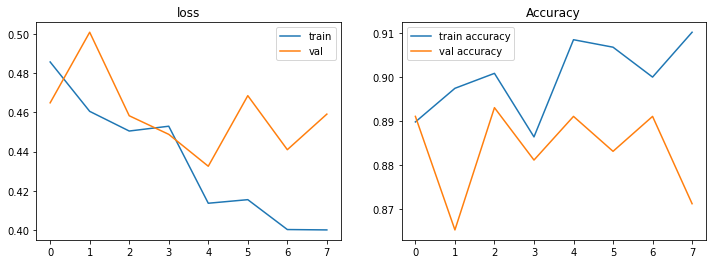

In [142]:
plot_history(history)

In [143]:
y_pred = model.predict(X_test)

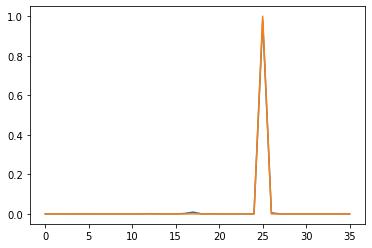

In [144]:
plt.plot(y_pred[800])
plt.plot(y_test[800])

## extrenal test dataset

(904, 904, 3)

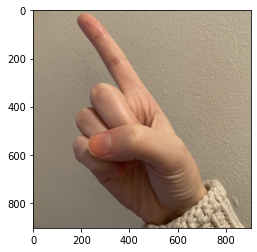

In [145]:
im = Image.open('/content/drive/MyDrive/signproject/phone_pictures/sample2.png')
im = np.array(im.convert('RGB'))/255
plt.imshow(im)
im.shape

In [149]:
resize_image_test = Sequential(layers.Resizing(img_size,img_size))
im = resize_image_test(np.array(im1))

In [150]:
xa = np.reshape(test,(1,100,100,3))

In [151]:
lb.inverse_transform(model.predict(xa))



array(['z'], dtype='<U1')

(904, 904, 3)

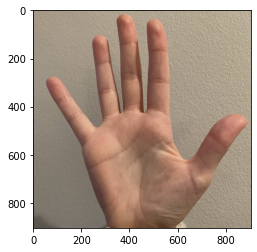

In [101]:
# im1 = Image.open('/content/drive/MyDrive/signproject/phone_pictures/sample4.png')
# im1 = np.array(im1.convert('RGB'))/255
# plt.imshow(im1)
# im1.shape

In [102]:
# resize_image(im1).shape

TensorShape([100, 100, 3])

In [93]:
# test1 = rescale(im1, (0.111,0.111,1), anti_aliasing=False)
# test1.shape

(100, 100, 3)

In [94]:
# xa1 = np.reshape(test1,(1,100,100,3))

In [95]:
# lb.inverse_transform(model.predict(xa1))

array(['5'], dtype='<U1')

In [ ]:
# im2 = Image.open('/content/drive/MyDrive/signproject/phone_pictures/WhatsApp Image 2021-11-23 at 21.44.37.jpeg')
# im2 = im2.convert('RGB')
# im2 = im2.transpose(method=Image.FLIP_LEFT_RIGHT)
# im2 = np.array(im2)/255
# # plt.imshow(im2)
# im2.shape
# test2 = rescale(im2, (0.0625,0.083,1), anti_aliasing=False)
# test2.shape
# xa2 = np.reshape(test2,(1,100,100,3))
# lb.inverse_transform(model.predict(xa2))

In [ ]:
# im2 = Image.open('/content/drive/MyDrive/signproject/phone_pictures/WhatsApp Image 2021-11-23 at 21.44.38 (1).jpeg')
# im2 = im2.convert('RGB')
# im2 = im2.transpose(method=Image.FLIP_LEFT_RIGHT)
# im2 = np.array(im2)/255
# plt.imshow(im2)
# im2.shape
# test2 = rescale(im2, (0.0625,0.083,1), anti_aliasing=False)
# test2.shape
# xa2 = np.reshape(test2,(1,100,100,3))
# lb.inverse_transform(model.predict(xa2))

In [ ]:
# im2 = Image.open('/content/drive/MyDrive/signproject/phone_pictures/WhatsApp Image 2021-11-23 at 21.44.38 (2).jpeg')
# im2 = im2.convert('RGB')
# # im2 = im2.transpose(method=Image.FLIP_LEFT_RIGHT)
# im2 = np.array(im2)/255
# plt.imshow(im2)
# im2.shape
# test2 = rescale(im2, (0.0625,0.083,1), anti_aliasing=False)
# test2.shape
# xa2 = np.reshape(test2,(1,100,100,3))
# lb.inverse_transform(model.predict(xa2))